In [1]:
import scanpy as sc
import scvi
import muon as mu
import scib

In [2]:
mudata = mu.read("/home/icb/dominik.klein/git_repos/moscot_revisions/scMultiome_Mouse-Islets_NVF_E14-E16/scMultiome_Mouse-Islets_NVF_E14-E16_mdata_markedDoublets_mergedPeaks_normalized_rmDoublets.h5mu")

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [3]:
n_hidden=1024
n_latent=50
n_layers=4

batch_key = 'experiment_batch'

deeply_inject_covariates = True

modality_weights = 'cell'
model_depth = True

In [4]:
adata_gex = mudata["rna"]
adata_atac = mudata["atac"]

In [5]:
sc.pp.highly_variable_genes(
    adata_gex,
    n_top_genes=2000,
    subset=True,
    layer="raw_counts",
    flavor="seurat_v3",
    batch_key="experiment_batch",
)

In [7]:
print("# regions before filtering:", adata_atac.shape[-1])

# compute the threshold: 5% of the cells
min_cells = int(adata_atac.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata_atac, min_cells=min_cells)

print("# regions after filtering:", adata_atac.shape[-1])

# regions before filtering: 56582
# regions after filtering: 56582


In [8]:
adata_gex.X = adata_gex.layers["raw_counts"]
adata_atac.X = adata_atac.layers["atac_raw_counts"]

In [9]:
# Joint data
adata_multi = adata_gex.copy().transpose().concatenate(adata_atac.copy().transpose()).transpose()

# Add modality to .obs
adata_multi.obs['modality'] = 'Multiome'

# Fix var_names
adata_multi.var_names = list(adata_gex.var_names) + list(adata_atac.var_names)

# Clean up .obs
adata_multi.obs = adata_multi.obs.loc[:,['sample', 'name', 'stage', 'stage_num', 'int_id', 'seq_id_gex_id', 'seq_id_atac', 'reporter', 'experiment_batch', 'sequencing_batch', 'final_doublets', 'final_doublets_cat', 'doublet_calls', 'batch']].copy()

/tmp/ipykernel_3815210/1893873216.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_multi = adata_gex.copy().transpose().concatenate(adata_atac.copy().transpose()).transpose()
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release

In [10]:
scvi.model.MULTIVI.setup_anndata(adata_multi, batch_key=batch_key)

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:117: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [11]:
model_mvi = scvi.model.MULTIVI(
    adata_multi,
    n_genes=(adata_multi.var['feature_types']=='Gene Expression').sum(),
    n_regions=(adata_multi.var['feature_types']=='Peaks').sum(),
    n_hidden=n_hidden,
    n_latent=n_latent, 
    n_layers_encoder=n_layers,
    n_layers_decoder=n_layers,
    deeply_inject_covariates=deeply_inject_covariates,
    #modality_weights=modality_weights,
    #model_depth=model_depth,
    #gene_dispersion='gene-batch'
)
model_mvi.view_anndata_setup()

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Anndata setup with scvi-tools version 1.1.0rc1.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'experiment_batch',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 22653 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 58582 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                        batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['experiment_batch'] │   Exp_1    │          0          │
│                               │   Exp_2    │          1          │
└───────────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                        batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['experiment_batch'] │   Exp_1    │          0          │
│                               │   Exp_2    │          1          │
└───────────────────────────────┴────────────┴─────────────────────┘

In [12]:
model_mvi.train()

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/scvi-tools/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/scvi-tools/l ...
  rank_zero_warn(
You are using a CUDA device ('NVID

Epoch 96/500:  19%|█▉        | 95/500 [2:14:21<9:33:57, 85.03s/it, v_num=1, train_loss_step=2.25e+4, train_loss_epoch=2.09e+4] 

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


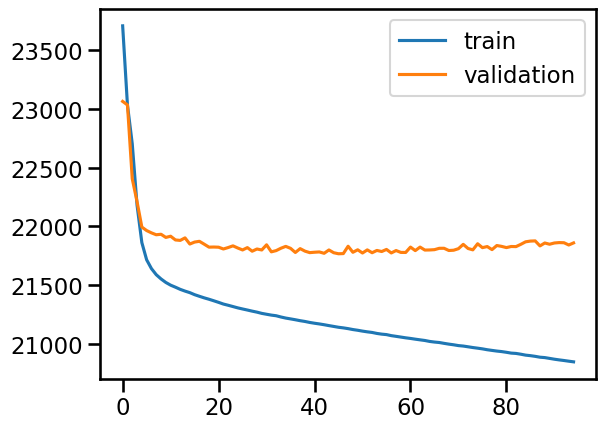

In [14]:
import matplotlib.pyplot as plt
plt.plot(model_mvi.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model_mvi.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')
plt.legend()

In [17]:
adata_multi.obsm['X_MultiVI'] = model_mvi.get_latent_representation(adata_multi)

In [19]:
sc.pp.neighbors(adata_multi, use_rep='X_MultiVI')

In [20]:
sc.tl.umap(adata_multi)

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


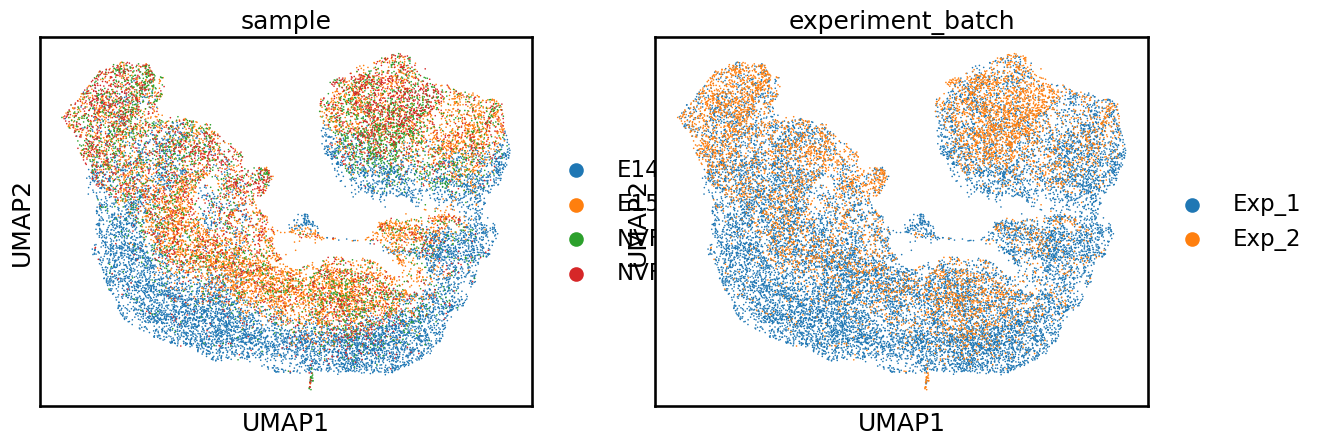

In [21]:
sc.pl.umap(adata_multi, color=["sample", "experiment_batch"])

In [22]:
adata_multi.write("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/adata_multiVI.h5ad")

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/tempfile.py:895: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmpn5tscrhw'>
  _warnings.warn(warn_message, ResourceWarning)
